In [1]:
import numpy as np

In [2]:
class neuralNetwork:    
    
    def __init__(
        self,
        input_neurons,  # 入力層のニューロン数
        hidden_neurons, # 隠れ層のニューロン数
        output_neurons, # 出力層のニューロン数
        learning_rate   # 学習率
        ):
        '''
        ニューラルネットワークの初期化を行う

        '''
        # 入力層、隠れ層、出力層のニューロン数をインスタンス変数に代入
        self.inneurons = input_neurons # 入力層のニューロン数
        self.hneurons = hidden_neurons # 隠れ層のニューロン数
        self.oneurons = output_neurons # 出力層のニューロン数
        self.lr = learning_rate        # 学習率
        self.weight_initializer()      # weight_initializer()を呼ぶ

    def weight_initializer(self):
        '''
        重みとバイアスの初期化を行う
        
        '''
        # 隠れ層の重みとバイアスを初期化
        self.w1 = np.random.normal(
            0.0,                       # 平均は0
            pow(self.inneurons, -0.5), # 標準偏差は入力層のニューロン数を元に計算
            (self.hneurons,            # 行数は隠れ層のニューロン数
             self.inneurons + 1)       # 列数は入力層のニューロン数 + 1
            )
        
       # 出力層の重みとバイアスを初期化
        self.w2 = np.random.normal(
            0.0,                      # 平均は0
            pow(self.hneurons, -0.5), # 標準偏差は隠れ層のニューロン数を元に計算
            (self.oneurons,           # 行数は出力層のニューロン数
             self.hneurons + 1)       # 列数は隠れ層のニューロン数 + 1
            )
    
    def sigmoid(self, x):
        '''
        シグモイド関数
        ------------------------
        x : 関数を適用するデータ
        '''
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        '''
        ソフトマックス関数
        ------------------------
        x : 関数を適用するデータ
        '''
        c = np.max(x)
        exp_x = np.exp(x - c) # オーバーフローを防止する
        sum_exp_x = np.sum(exp_x)
        y = exp_x / sum_exp_x
        return y
    
    def train(self, inputs_list, targets_list):
        '''
        ニューラルネットワークの学習を行う
        ------------------------
        inputs_list  : 訓練データの配列
        targets_list : 正解ラベルの配列
        
        '''
        ## [入力層]
        # 入力値の配列にバイアス項を追加して入力層から出力する
        inputs = np.array(
            np.append(
                inputs_list, [1]), # 配列の末尾にバイアスのための「1」を追加
            ndmin=2                # 2次元化
        ).T                        # 転置して1列の行列にする

        ## [隠れ層]
        # 入力層の出力に重み、バイアスを適用して隠れ層に入力する
        hidden_inputs = np.dot(
            self.w1,              # 隠れ層の重み
            inputs                # 入力層の出力
            )
        # シグモイド関数を適用して隠れ層から出力
        hidden_outputs = self.sigmoid(hidden_inputs)        
        # 隠れ層の出力行列の末尾にバイアスのための「1」を追加
        hidden_outputs = np.append(
            hidden_outputs,      # 隠れ層の出力行列
            [[1]],               # 2次元形式でバイアス値を追加
            axis=0               # 行を指定(列は1)
            )
        
        ## [出力層]
        # 出力層への入力信号を計算
        final_inputs = np.dot(
            self.w2,             # 隠れ層と出力層の間の重み
            hidden_outputs       # 隠れ層の出力
            )
        # ソフトマックス関数を適用して出力層から出力する
        final_outputs = self.softmax(final_inputs)
        
        ## ---バックプロパゲーション---(出力層)
        # 正解ラベルの配列を1列の行列に変換する
        targets = np.array(
            targets_list,        # 正解ラベルの配列
            ndmin=2              # 2次元化
            ).T                  # 転置して1列の行列にする
        # 出力値と正解ラベルとの誤差
        output_errors = final_outputs - targets
        # 出力層の入力誤差δを求める
        delta_output = output_errors*(1 - final_outputs)*final_outputs
        # 重みを更新する前に隠れ層の出力誤差を求めておく
        hidden_errors = np.dot(
            self.w2.T,           # 出力層の重み行列を転置する
            delta_output         # 出力層の入力誤差δ
            )
        # 出力層の重み、バイアスの更新
        self.w2 -= self.lr * np.dot(
            # 出力誤差＊(1－出力信号)＊出力信号 
            delta_output,
            # 隠れ層の出力行列を転置
            hidden_outputs.T
        )
        
        ## ---バックプロパゲーション---(隠れ層)
        # 逆伝搬された隠れ層の出力誤差からバイアスのものを取り除く
        hidden_errors_nobias = np.delete(
            hidden_errors,      # 隠れ層のエラーの行列
            self.hneurons,      # 隠れ層のニューロン数をインデックスにする
            axis=0              # 行の削除を指定
            )
        # 隠れ層の出力行列からバイアスを除く
        hidden_outputs_nobias = np.delete(
            hidden_outputs,     # 隠れ層の出力の行列
            self.hneurons,      # 隠れ層のニューロン数をインデックスにする
            axis=0              # 行の削除を指定
            )
        # 隠れ層の重み、バイアスの更新
        self.w1 -= self.lr * np.dot(
            # 逆伝搬された隠れ層の出力誤差＊(1－隠れ層の出力)＊隠れ層の出力 
            hidden_errors_nobias*(
                1.0 - hidden_outputs_nobias
            )*hidden_outputs_nobias,
            # 入力層の出力信号の行列を転置
            inputs.T
            )
   
    def evaluate(self,
                 inputs_list
                ):
        '''
        学習した重みでテストデータを評価する
        ------------------------------------
        inputs_list : テスト用データの配列
        
        '''
        ## [入力層]
        # 入力値の配列にバイアス項を追加して入力層から出力する
        inputs = np.array(
            np.append(inputs_list, [1]), # 配列の末尾にバイアスの値「1」を追加
            ndmin=2                      # 2次元化
        ).T                              # 転置して1列の行列にする
        
        ## [隠れ層]
        # 入力層の出力に重み、バイアスを適用して隠れ層に入力する
        hidden_inputs = np.dot(self.w1,  # 入力層と隠れ層の間の重み
                               inputs    # テストデータの行列
                              )       
        # 活性化関数を適用して隠れ層から出力する
        hidden_outputs = self.sigmoid(hidden_inputs)
        
        ## [出力層]
        # 出力層への入力信号を計算
        final_inputs = np.dot(
            self.w2,                        # 隠れ層と出力層の間の重み
            np.append(hidden_outputs, [1]), # 隠れ層の出力配列の末尾にバイアスの値「1」を追加
            )       
        # 活性化関数を適用して出力層から出力する
        final_outputs = self.softmax(final_inputs)
        
        # 出力層からの出力を戻り値として返す
        return final_outputs

In [3]:
from keras.datasets import fashion_mnist
(x_trains, y_trains), (x_tests, y_tests) = fashion_mnist.load_data()

Using TensorFlow backend.


In [4]:
# 60000x28x28の2次元配列を60000×784の行列に変換
x_trains = x_trains.reshape(60000, 784)
# データを255で割って0.99を掛けた後、0.01を加えてシフトする
x_trains = (x_trains / 255.0 * 0.99) + 0.01

In [5]:
import time            # 時間を測定するモジュールをインポート

start = time.time()    # プログラムの開始時刻を取得

input_neurons = 784    # 入力層のニューロンの数
hidden_neuronss = 200  # 隠れ層のニューロンの数
output_neurons = 10    # 出力層のニューロンの数
learning_rate = 0.2    # 学習率

# neuralNetworkクラスのインスタンス化
n = neuralNetwork(input_neurons,
                  hidden_neuronss,
                  output_neurons,
                  learning_rate)

# ニューラルネットワークの学習
epochs = 5            # 学習を繰り返す回数

# 指定した回数だけ学習を繰り返す
for e in range(1):
    # 画像データと正解ラベルを1セットずつ取り出す
    for (inputs, target) in zip(x_trains, y_trains):
        # 出力層のニューロン数を要素数とするOne-hotベクトルを作成
        targets = np.zeros(output_neurons) + 0.01
        # 正解ラベルに対応する要素を0.99にする
        targets[int(target)] = 0.99
        # 画像データと正解ラベルの1セットを引数にしてtrain()を実行
        n.train(inputs,  # 訓練データの行列
                targets  # 目標値の行列
               )
        
# 学習終了後、学習に要した時間を出力
print("Computation time:{0:.3f} sec".format(time.time() - start))

Computation time:89.094 sec


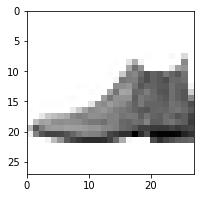

9


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# グラフエリアのサイズを3×3にする
plt.ﬁgure(ﬁgsize=(3, 3))
# グレースケールにする
plt.gray()        
# 1番目の784個のピクセル値を28×28の行列にする
img = x_tests[0, :, :].reshape(28, 28)
# 色相を反転させてプロットする
plt.pcolor(255 - img)
plt.xlim(0, 27)   # x軸を0~28の範囲
plt.ylim(27, 0)   # y軸を28~0の範囲
plt.show()

print(y_tests[0]) # 1番目の正解ラベルを出力

In [7]:
# 10000x28x28の2次元配列を10000×784の行列に変換
x_tests = x_tests.reshape(10000, 784)
# データを255で割って0.99を掛けた後、0.01を加えてシフトする
x_tests = (x_tests / 255.0 * 0.99) + 0.01

# 正解は1、不正解は0を格納する配列
score = []

# x_testsをinputs、y_testsをcorrect_labelに格納
for (inputs,
     correct_label) in zip(x_tests, y_tests):
    # ニューラルネットワークで評価する
    outputs = n.evaluate(inputs)
    # 出力層のニューロン数に合わせて正解の配列を作成
    targets = np.zeros(output_neurons) + 0.01
    # 正解値に対応する要素を0.99にする
    targets[int(target)] = 0.99
    # 出力の行列の最大値のインデックスが予測する手書き数字に対応
    label = np.argmax(outputs)
    # ネットワークの出力と正解ラベルを比較
    if (label == correct_label):
        # 正解ならscoreに1を追加
        score.append(1)
    else:
        # 不正解なら0を追加
        score.append(0)

In [8]:
result = ['〇' if i  == 1 else '●' for i in score]
print(result)

['〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '●', '〇', '●', '〇', '●', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '●', '●', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '●', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '●', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '●', '〇', '●', '〇', '●', '●', '●', '〇', '●', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '〇', '●', '〇', '〇', '〇', '〇', '〇', '〇', '〇',

In [9]:
# 配列scoreをNumPy配列に変換
score_arry = np.asarray(score)
# score_arryの合計をscore_arryの要素数で割って正解率を求める 
print ("performance = ",
       score_arry.sum() / score_arry.size)

performance =  0.8362
